In [42]:
# Librerias
import warnings
warnings.filterwarnings("ignore")
#import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
from sklearn.model_selection import train_test_split, cross_val_score
#import xgboost as xgb
#from xgboost import XGBRegressor
#from xgboost import plot_importance

In [43]:
# leer ambos archivos
df_original = pd.read_csv("../data/raw/power_tetouan_city_original.csv")
df_modified = pd.read_csv("../data/raw/power_tetouan_city_modified.csv")

In [44]:
df_original.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


df_modified.head()

In [45]:
df_modified.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,mixed_type_col
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,NaN,34055.6962,16128.87538,20240.96386,624
1,1/1/2017 0:10,6.414,74.5,0.083,0.07,0.085,29814.68354,19375.07599,20131.08434,811
2,1/1/2017 0:20,6.313,74.5,0.08,0.062,0.1,29128.10127,19006.68693,19668.43373,unknown
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,bad
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.6962,17872.34043,18442.40964,879


In [46]:
# Renombrar variables 
df_modified = df_modified.rename(columns={'Zone 1 Power Consumption': 'PC_Zone1', 
                        'Zone 2  Power Consumption': 'PC_Zone2',
                        'Zone 3  Power Consumption': 'PC_Zone3'})

In [47]:
# Información del dataset
df_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53464 entries, 0 to 53463
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   DateTime               52977 non-null  object
 1   Temperature            52880 non-null  object
 2   Humidity               52826 non-null  object
 3   Wind Speed             52846 non-null  object
 4   general diffuse flows  52838 non-null  object
 5   diffuse flows          52849 non-null  object
 6   PC_Zone1               52861 non-null  object
 7   PC_Zone2               52839 non-null  object
 8   PC_Zone3               52889 non-null  object
 9   mixed_type_col         48162 non-null  object
dtypes: object(10)
memory usage: 4.1+ MB


In [48]:
# Drop NA
df_clean = df_modified.dropna()

In [49]:
df_clean = df_clean.drop_duplicates()

In [50]:
df_clean

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,PC_Zone1,PC_Zone2,PC_Zone3,mixed_type_col
1,1/1/2017 0:10,6.414,74.5,0.083,0.07,0.085,29814.68354,19375.07599,20131.08434,811
2,1/1/2017 0:20,6.313,74.5,0.08,0.062,0.1,29128.10127,19006.68693,19668.43373,unknown
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,bad
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.6962,17872.34043,18442.40964,879
5,1/1/2017 0:50,5.853,76.9,0.081,0.059,0.108,26624.81013,17416.41337,18130.12048,801
...,...,...,...,...,...,...,...,...,...,...
53459,10/25/2017 4:10,17.95,89.0,4.916,0.059,0.185,24672.21007,15834.0249,10662.12766,638
53460,12/3/2017 16:00,14.43,75.6,0.082,60.16,61.03,26950.57034,21437.25069,9605.762305,472
53461,3/1/2017 15:50,21.59,54.67,0.086,516.0,357.9,32372.42553,20465.85366,15996.77419,bad
53462,7/22/2017 3:00,27.65,27.18,4.904,0.113,?,29189.10299,19830.37975,25361.07531,731


In [51]:
# Información del dataset limpio
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43505 entries, 1 to 53463
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   DateTime               43505 non-null  object
 1   Temperature            43505 non-null  object
 2   Humidity               43505 non-null  object
 3   Wind Speed             43505 non-null  object
 4   general diffuse flows  43505 non-null  object
 5   diffuse flows          43505 non-null  object
 6   PC_Zone1               43505 non-null  object
 7   PC_Zone2               43505 non-null  object
 8   PC_Zone3               43505 non-null  object
 9   mixed_type_col         43505 non-null  object
dtypes: object(10)
memory usage: 3.7+ MB


In [52]:
# Descrbir el dataset
df_clean.describe()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,PC_Zone1,PC_Zone2,PC_Zone3,mixed_type_col
count,43505,43505,43505,43505,43505,43505,43505,43505,43505,43505
unique,42875,5054,5873,1049,10834,10804,26483,27939,22549,1002
top,NAN,?,84.6,0.082,0.062,0.115,?,error,error,unknown
freq,18,50,159,1784,1221,976,49,44,45,4939


In [53]:
# 🔹 Convertimos DateTime a formato datetime real
df_clean["DateTime"] = pd.to_datetime(df_clean["DateTime"], errors="coerce")

# 🔹 Creamos solo las columnas que te interesan
df_clean["hour"] = df_clean["DateTime"].dt.hour
df_clean["day"] = df_clean["DateTime"].dt.day
df_clean["month"] = df_clean["DateTime"].dt.month
df_clean["year"] = df_clean["DateTime"].dt.year

# 🔹 Eliminamos columnas no necesarias
df_clean = df_clean.drop(columns=["DateTime", "mixed_type_col"], errors="ignore")

# 🔹 Convertimos las demás columnas a numéricas (por si quedaron como texto)
for col in df_clean.columns:
    df_clean[col] = (
        df_clean[col].astype(str).str.replace(",", ".")
    )
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

In [54]:
df_clean

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,PC_Zone1,PC_Zone2,PC_Zone3,hour,day,month,year
1,6.414,74.50,0.083,0.070,0.085,29814.68354,19375.07599,20131.084340,0.0,1.0,1.0,2017.0
2,6.313,74.50,0.080,0.062,0.100,29128.10127,19006.68693,19668.433730,0.0,1.0,1.0,2017.0
3,6.121,75.00,0.083,0.091,0.096,28228.86076,18361.09422,18899.277110,0.0,1.0,1.0,2017.0
4,5.921,75.70,0.081,0.048,0.085,27335.69620,17872.34043,18442.409640,0.0,1.0,1.0,2017.0
5,5.853,76.90,0.081,0.059,0.108,26624.81013,17416.41337,18130.120480,0.0,1.0,1.0,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...
53459,17.950,89.00,4.916,0.059,0.185,24672.21007,15834.02490,10662.127660,4.0,25.0,10.0,2017.0
53460,14.430,75.60,0.082,60.160,61.030,26950.57034,21437.25069,9605.762305,16.0,3.0,12.0,2017.0
53461,21.590,54.67,0.086,516.000,357.900,32372.42553,20465.85366,15996.774190,15.0,1.0,3.0,2017.0
53462,27.650,27.18,4.904,0.113,NaN,29189.10299,19830.37975,25361.075310,3.0,22.0,7.0,2017.0


In [55]:
df_clean.dtypes

Temperature              float64
Humidity                 float64
Wind Speed               float64
general diffuse flows    float64
diffuse flows            float64
PC_Zone1                 float64
PC_Zone2                 float64
PC_Zone3                 float64
hour                     float64
day                      float64
month                    float64
year                     float64
dtype: object

In [62]:
df_clean.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,PC_Zone1,PC_Zone2,PC_Zone3,hour,day,month,year
count,43333.00000,43341.000000,43358.000000,43344.000000,43351.000000,4.334000e+04,4.336300e+04,4.335500e+04,41314.000000,41314.000000,41314.000000,41314.0
mean,27.94517,90.239076,5.547224,225.174584,100.073635,4.162037e+04,2.632479e+04,2.282766e+04,11.530304,15.683182,6.520744,2017.0
std,174.17370,300.580076,82.290949,1191.952324,579.447699,1.463158e+05,8.863801e+04,8.350098e+04,6.911106,8.786136,3.441861,0.0
min,3.24700,11.340000,0.050000,0.004000,0.011000,1.389570e+04,8.560081e+03,5.935174e+03,0.000000,1.000000,1.000000,2017.0
25%,14.48000,58.350000,0.078000,0.066000,0.122000,2.638004e+04,1.702154e+04,1.315988e+04,6.000000,8.000000,4.000000,2017.0
50%,18.94000,69.990000,0.086000,6.704000,6.165000,3.234667e+04,2.088493e+04,1.645218e+04,12.000000,16.000000,7.000000,2017.0
75%,23.10000,81.700000,4.915000,330.500000,104.500000,3.746238e+04,2.483326e+04,2.180013e+04,17.000000,23.000000,10.000000,2017.0
max,28149.24000,8460.000000,14337.903000,62313.600000,44602.800000,4.661783e+06,2.958428e+06,3.566782e+06,23.000000,31.000000,12.000000,2017.0


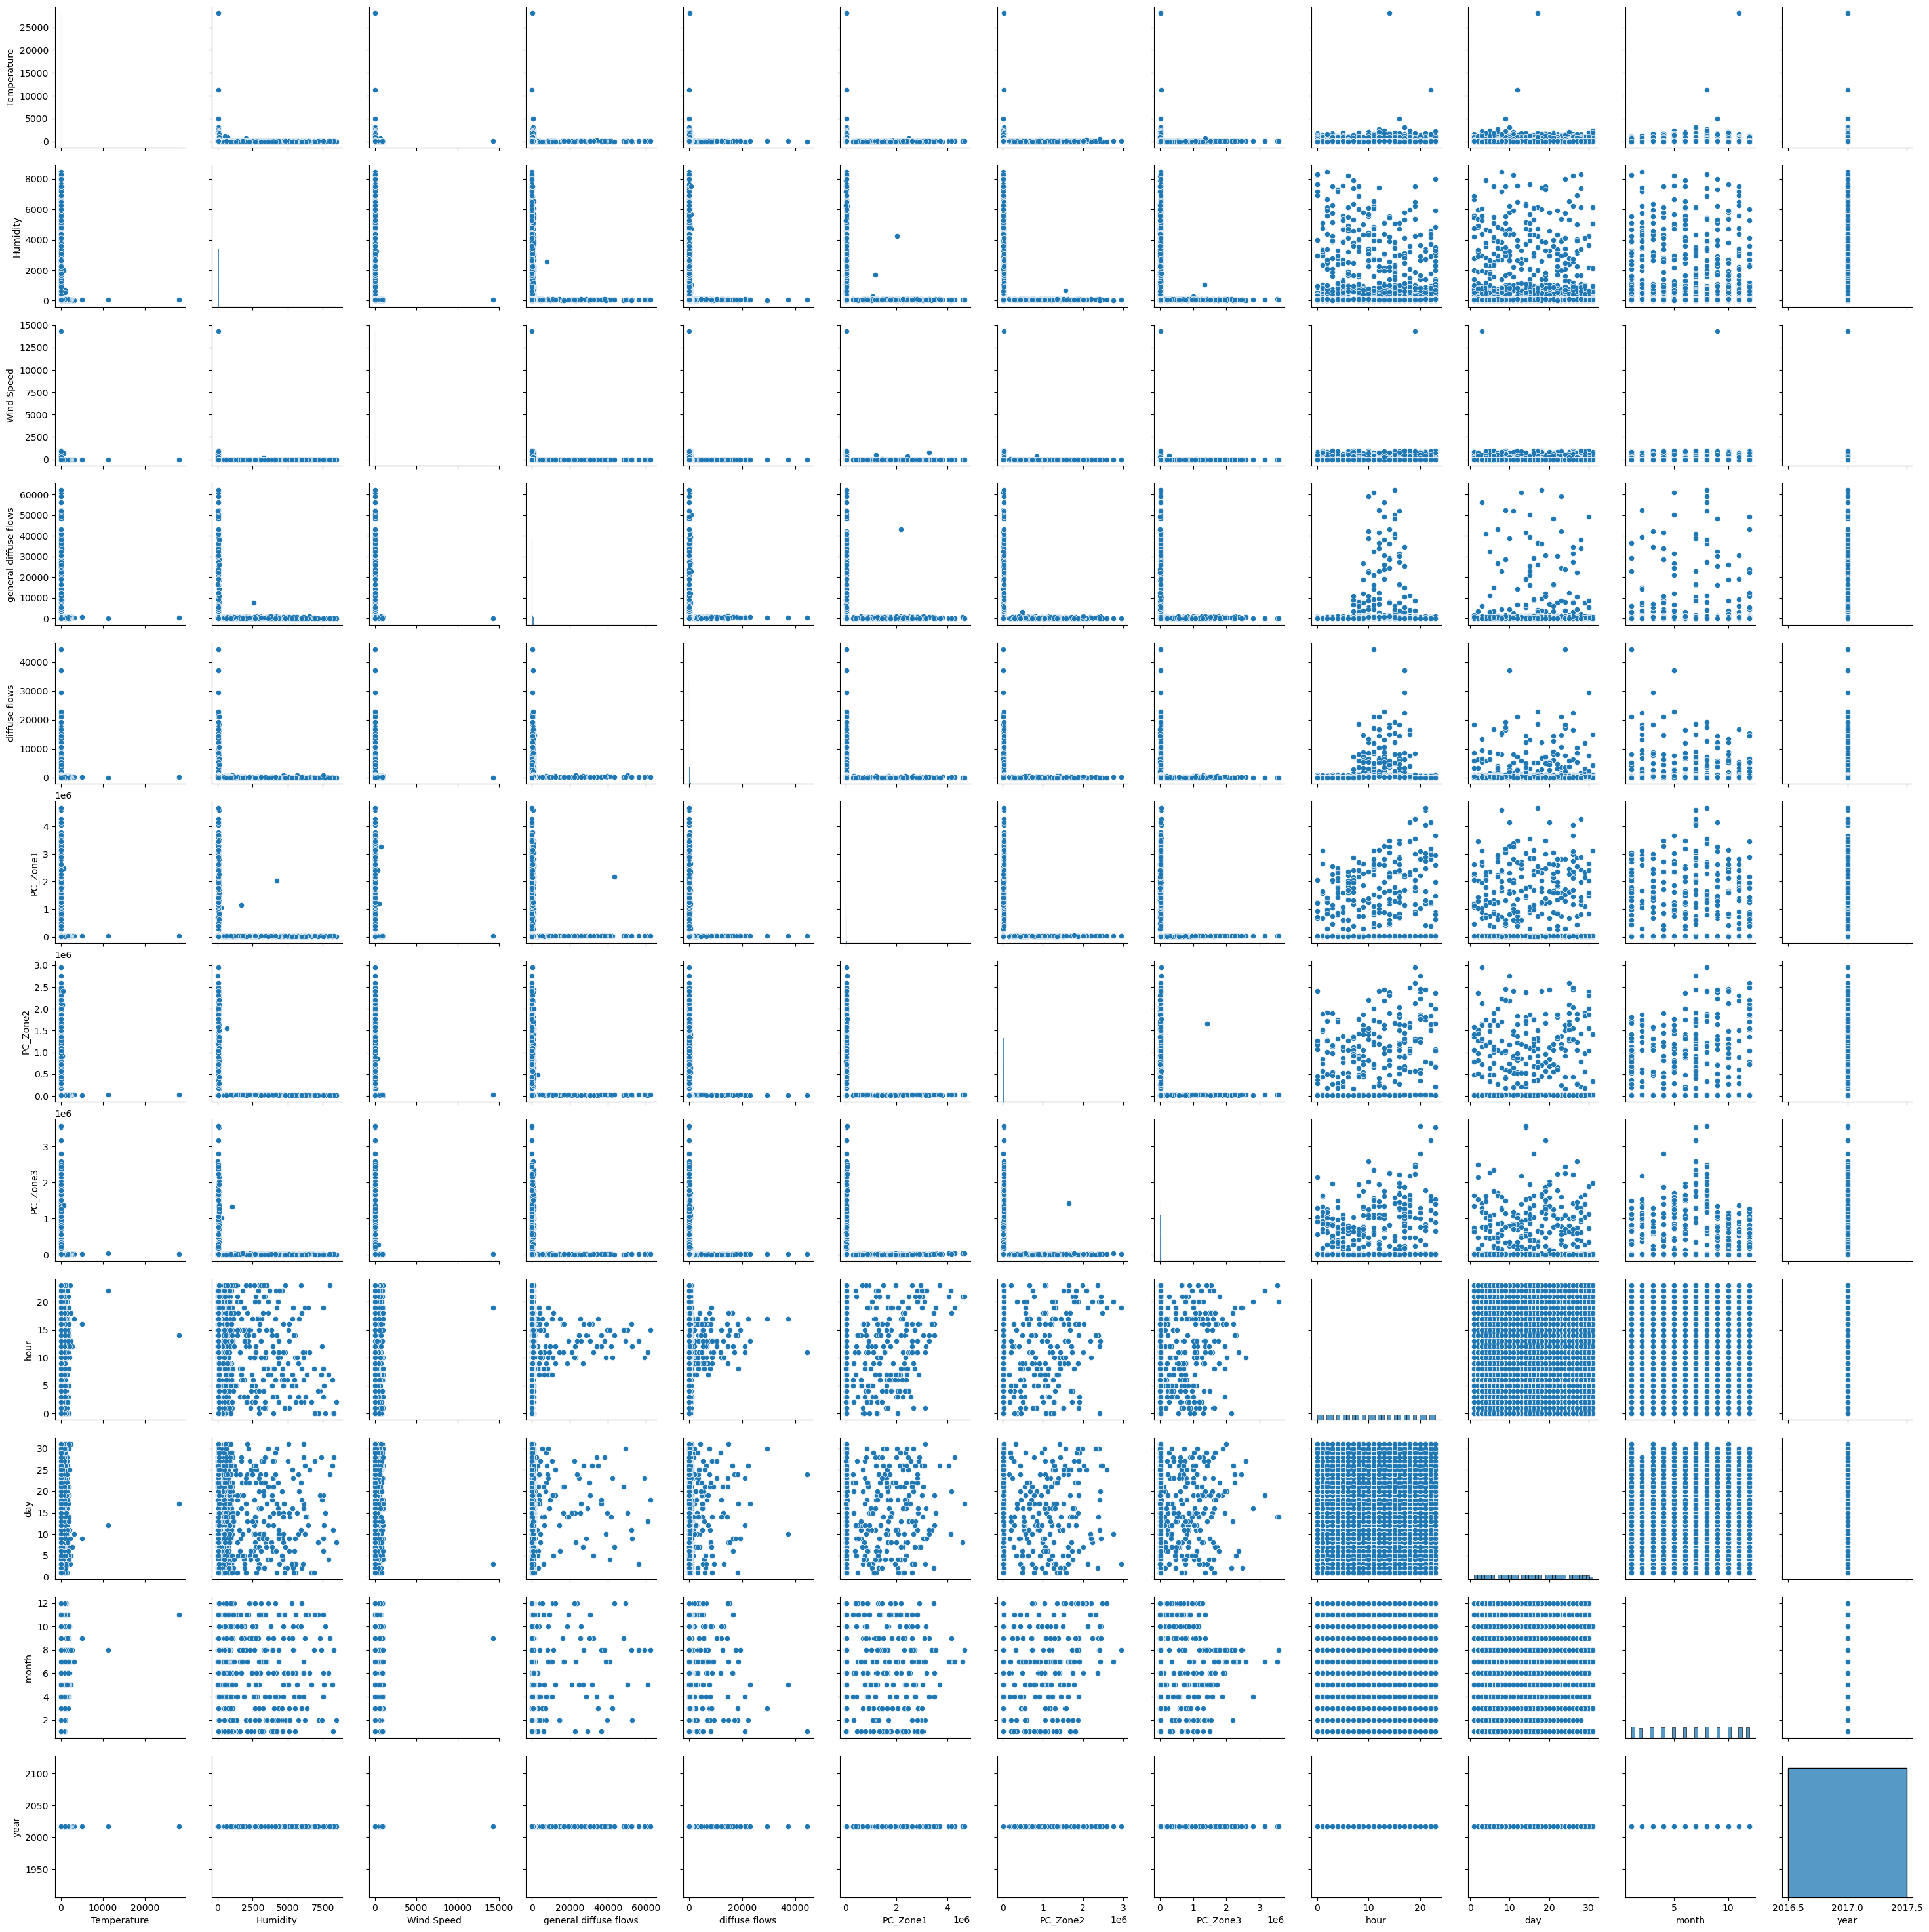

In [56]:
#pairplot para ver comportamientos y relaciones entre variables
sns.pairplot(df_clean)
plt.show()

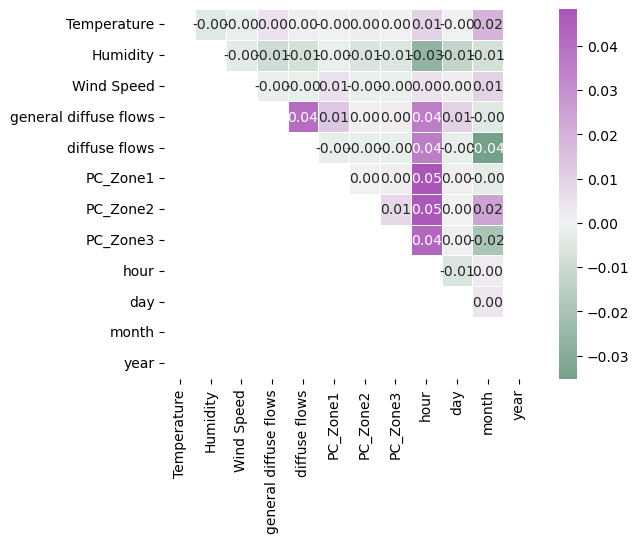

In [57]:
corr = df_clean.corr()
mask = np.tril(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask, fmt=".2f", square=True, linewidths=0.5, 
            cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True), center=0)
plt.show()

In [61]:
# Definimos variables con mayor impacto en la correlación
def impact_corr(df_clean, umbral=0.2):
    # Correlación
    cor = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).stack().reset_index())
    cor.columns = ['Variable 1', 'Variable 2', 'Correlacion']
    
    # Umbral
    corr_umb = cor[cor['Correlacion'].abs()>=umbral].sort_values(by='Correlacion', key=abs, ascending=False)
    return corr_umb

corr_vars = impact_corr(df_clean, umbral=0.4)
print(corr_vars)

Empty DataFrame
Columns: [Variable 1, Variable 2, Correlacion]
Index: []
